In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

import time

In [20]:
# tf.debugging.set_log_device_placement(True)

# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [21]:
DF_PATH = 'data/train.csv'
USE_COLUMNS = ['ETHUSD_Close_log','ZECUSD_Close_log','LTCUSD_Close_log','BTCUSD_Close_log']
TRAIN_SIZE = 0.7
TIME_WINDOW = 100
DATA_USE = 500000

In [22]:
# Read train file
train_df = pd.read_csv(DF_PATH)
train_df.sort_values('Date')
train_df.head()

,Date,ETHUSD_Volume,ZECUSD_Volume,LTCUSD_Volume,BTCUSD_Volume,ETHUSD_Open_log,ETHUSD_High_log,ETHUSD_Low_log,ETHUSD_Close_log,ZECUSD_Open_log,...,ZECUSD_Low_log,ZECUSD_Close_log,LTCUSD_Open_log,LTCUSD_High_log,LTCUSD_Low_log,LTCUSD_Close_log,BTCUSD_Open_log,BTCUSD_High_log,BTCUSD_Low_log,BTCUSD_Close_log
0,2019-03-19 00:00:00,2.506756,0.0,0.00000,0.000000,4.921294,4.921294,4.920492,4.920492,3.983785,...,3.983785,3.983785,4.073291,4.073291,4.073291,4.073291,8.283757,8.283757,8.283757,8.283757
1,2019-03-19 00:01:00,4.146010,0.0,0.00000,0.000000,4.920492,4.920492,4.919251,4.919251,3.983785,...,3.983785,3.983785,4.073291,4.073291,4.073291,4.073291,8.283757,8.283757,8.283757,8.283757
2,2019-03-19 00:02:00,10.000000,0.0,0.49999,0.000000,4.919251,4.919251,4.918885,4.918885,3.983785,...,3.983785,3.983785,4.073291,4.073291,4.073291,4.073291,8.283757,8.283757,8.283757,8.283757
3,2019-03-19 00:03:00,0.000000,0.0,33.62118,0.030867,4.918885,4.918885,4.918885,4.918885,3.983785,...,3.983785,3.983785,4.073291,4.073291,4.073291,4.073291,8.283757,8.284350,8.283757,8.284350
4,2019-03-19 00:04:00,0.000000,0.0,11.01871,2.286674,4.918885,4.918885,4.918885,4.918885,3.983785,...,3.983785,3.983785,4.073291,4.073291,4.073291,4.073291,8.284350,8.284353,8.283759,8.283759


In [5]:
# Check the dataset is sorted by "Date" 
# And tha last date is 2021/03/18, 23:59 
train_df.tail(-1440)

,Date,ETHUSD_Volume,ZECUSD_Volume,LTCUSD_Volume,BTCUSD_Volume,ETHUSD_Open_log,ETHUSD_High_log,ETHUSD_Low_log,ETHUSD_Close_log,ZECUSD_Open_log,...,ZECUSD_Low_log,ZECUSD_Close_log,LTCUSD_Open_log,LTCUSD_High_log,LTCUSD_Low_log,LTCUSD_Close_log,BTCUSD_Open_log,BTCUSD_High_log,BTCUSD_Low_log,BTCUSD_Close_log
1440,2019-03-20 00:00:00,0.000000,0.000000,0.00000,0.131882,4.923478,4.923478,4.923478,4.923478,4.017464,...,4.017464,4.017464,4.077029,4.077029,4.077029,4.077029,8.291155,8.291155,8.291155,8.291155
1441,2019-03-20 00:01:00,0.000000,0.000000,0.00000,0.126791,4.923478,4.923478,4.923478,4.923478,4.017464,...,4.017464,4.017464,4.077029,4.077029,4.077029,4.077029,8.291155,8.291155,8.291155,8.291155
1442,2019-03-20 00:02:00,3.999354,0.000000,98.40303,0.949663,4.923478,4.923478,4.923042,4.923042,4.017464,...,4.017464,4.017464,4.077029,4.077029,4.075501,4.075501,8.291155,8.291155,8.290739,8.290739
1443,2019-03-20 00:03:00,0.000000,0.000000,1.59000,0.004971,4.923042,4.923042,4.923042,4.923042,4.017464,...,4.017464,4.017464,4.075501,4.075501,4.075501,4.075501,8.290739,8.290739,8.289911,8.289911
1444,2019-03-20 00:04:00,0.461938,0.000000,0.00000,0.024851,4.923042,4.923042,4.921950,4.921950,4.017464,...,4.017464,4.017464,4.075501,4.075501,4.075501,4.075501,8.289911,8.290082,8.289911,8.290082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986791,2021-03-18 23:55:00,8.084875,0.000000,19.63536,0.042762,7.492693,7.493724,7.492693,7.493328,4.976734,...,4.976734,4.976734,5.312122,5.314191,5.312122,5.314191,10.972620,10.973400,10.972518,10.973400
986792,2021-03-18 23:56:00,2.986374,0.000000,6.27173,0.493466,7.493328,7.494503,7.492693,7.493351,4.976734,...,4.976734,4.976734,5.314191,5.314240,5.313748,5.313748,10.973400,10.974774,10.973400,10.974290
986793,2021-03-18 23:57:00,0.544132,10.407404,5.00000,0.291972,7.493351,7.493351,7.492036,7.492777,4.976734,...,4.975699,4.975699,5.313748,5.313748,5.311924,5.311924,10.974290,10.974387,10.973042,10.973915
986794,2021-03-18 23:58:00,3.994954,0.000000,223.58507,16.107329,7.492777,7.492894,7.491517,7.491729,4.975699,...,4.975699,4.975699,5.311924,5.312812,5.311579,5.312812,10.973915,10.973915,10.971722,10.972547


In [23]:
# Extract close price of coins
# I just use close price in this prediction
df1 = train_df[USE_COLUMNS]
df1.head()

,ETHUSD_Close_log,ZECUSD_Close_log,LTCUSD_Close_log,BTCUSD_Close_log
0,4.920492,3.983785,4.073291,8.283757
1,4.919251,3.983785,4.073291,8.283757
2,4.918885,3.983785,4.073291,8.283757
3,4.918885,3.983785,4.073291,8.284350
4,4.918885,3.983785,4.073291,8.283759


In [24]:
# Describe the dataframe
df1.describe()

,ETHUSD_Close_log,ZECUSD_Close_log,LTCUSD_Close_log,BTCUSD_Close_log
count,986796.000000,986796.000000,986796.000000,986796.000000
mean,5.663591,4.062616,4.226380,9.308898
std,0.704343,0.398676,0.451200,0.576290
min,4.487287,2.890927,3.216072,8.259145
25%,5.171733,3.807107,3.847164,8.991196
50%,5.436992,4.080246,4.096841,9.165258
75%,5.955760,4.287304,4.479947,9.364627
max,7.620636,5.258120,5.509145,11.031159


In [8]:
# Check the null values
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986796 entries, 0 to 986795
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ETHUSD_Close_log  986796 non-null  float64
 1   ZECUSD_Close_log  986796 non-null  float64
 2   LTCUSD_Close_log  986796 non-null  float64
 3   BTCUSD_Close_log  986796 non-null  float64
dtypes: float64(4)
memory usage: 30.1 MB


In [25]:
# Get the number of data
df1.shape

(986796, 4)

In [26]:
# scale all columns 
# I am not sure is it useful
scaler_ETH = MinMaxScaler(feature_range=(0,1))
scaler_ZEC = MinMaxScaler(feature_range=(0,1))
scaler_LTC = MinMaxScaler(feature_range=(0,1))
scaler_BTC = MinMaxScaler(feature_range=(0,1))

tmp1 = scaler_ETH.fit_transform(np.array(df1.ETHUSD_Close_log).reshape(-1,1))
tmp2 = scaler_ZEC.fit_transform(np.array(df1.ZECUSD_Close_log).reshape(-1,1))
tmp3 = scaler_LTC.fit_transform(np.array(df1.LTCUSD_Close_log).reshape(-1,1))
tmp4 = scaler_BTC.fit_transform(np.array(df1.BTCUSD_Close_log).reshape(-1,1))

# df2 : scaled dataframe
df2 = pd.DataFrame()
df2['ETHUSD_Close_log'] = tmp1.flatten().tolist()
df2['ZECUSD_Close_log'] = tmp2.flatten().tolist()
df2['LTCUSD_Close_log'] = tmp3.flatten().tolist()
df2['BTCUSD_Close_log'] = tmp4.flatten().tolist()

# scale all volumns
if len(df1.columns) > 4:
    scaler = MinMaxScaler(feature_range=(0,1))
    df2[['ETHUSD_Volume', 'ZECUSD_Volume', 'LTCUSD_Volume','BTCUSD_Volume']] = scaler.fit_transform(df1[['ETHUSD_Volume', 'ZECUSD_Volume', 'LTCUSD_Volume','BTCUSD_Volume']])

dict_scaler =  {'ETH':scaler_ETH, 'ZEC':scaler_ZEC, 'LTC':scaler_LTC, 'BTC':scaler_BTC}

In [27]:
# Get the recent dataset
df_t = df2[-DATA_USE:]
# For validation after creating model
df_a = df1[-DATA_USE:]

In [28]:
# Split dataset into train and test
train_size = int(len(df_t)*TRAIN_SIZE)
train_df = df_t[:train_size]
validation_df = df_t[train_size:]

print(train_df.shape, validation_df.shape)

(350000, 4) (150000, 4)


In [29]:
df_t.head()

,ETHUSD_Close_log,ZECUSD_Close_log,LTCUSD_Close_log,BTCUSD_Close_log
486796,0.127121,0.254283,0.186338,0.173691
486797,0.127121,0.254283,0.186338,0.173691
486798,0.127675,0.254283,0.186338,0.173691
486799,0.127675,0.254283,0.185881,0.172864
486800,0.127675,0.254283,0.185881,0.172737


In [30]:
# Create sequancial info dataset from dataframe
def create_seq_dataset(df, window=3):
  x_data = []
  y_data = []
  for i in range(len(df)-window):
    # pre_time data
    tmp = df[i:i+window]
    x_data.append(tmp)
    # target data
    y_data.append(df.iloc[i+window])
  return np.array(x_data), np.array(y_data)

In [31]:
# Create sequancial info dataset from dataframe
X_train, y_train = create_seq_dataset(train_df,TIME_WINDOW)
X_valid, y_valid = create_seq_dataset(validation_df,TIME_WINDOW)

In [32]:
# Get dataset shape info
print(f'Shape of X_train : {X_train.shape}')
print(f'Shape of y_train : {y_train.shape}')
print(f'Shape of X_valid : {X_valid.shape}')
print(f'Shape of y_valid : {y_valid.shape}')

Shape of X_train : (349900, 100, 4)
Shape of y_train : (349900, 4)
Shape of X_valid : (149900, 100, 4)
Shape of y_valid : (149900, 4)


## Model training only one Coin Price

In [33]:
# dictionary for extracting interesting TARGET info 
# Use it when train a model for specific Coin
# PRE_TARGET
dict_target = {'ETH':0,'ZEC':1,'LTC':2,'BTC':3}

In [53]:
X_train[:,:,1].reshape(X_train.shape[0],X_train.shape[1],1)

TypeError: 'tuple' object cannot be interpreted as an integer

In [62]:
tmp_y_train.shape

(349900,)

In [63]:
# Set parameters
EPOCH = 50
BATCH_SIZE = 64
DESCRIBTION = '64_32_1_EachPred_batch64'

for target in dict_target.keys():
    # Create LSTM model
    with tf.device('/device:GPU:1'):
        model = Sequential()

        model.add(LSTM(64, input_shape=(X_train.shape[1],1), return_sequences=True))
        model.add(Dropout(0.3))
        model.add(BatchNormalization())

#         model.add(LSTM(32))
#         model.add(Dropout(0.3))
#         model.add(BatchNormalization())

        model.add(Dense(1))

        model.compile(loss='mean_squared_error', optimizer='adam')

    PRE_TARGET = target
    NAME = f'{DATA_USE}-{TIME_WINDOW}-window-{PRE_TARGET}-target-{DESCRIBTION}-{int(time.time())}'
    print(NAME)
    
    tensorboard = TensorBoard(log_dir=f'logs/{NAME}')

    mc = ModelCheckpoint(f'models/best_{NAME}.h5', monitor='val_loss', mode='min', save_best_only=True)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

    if PRE_TARGET != 'ALL':
        tmp_X_train = X_train[:,:,dict_target[PRE_TARGET]].reshape(X_train.shape[0],X_train.shape[1],1)
        tmp_y_train = y_train[:,dict_target[PRE_TARGET]]
        tmp_X_valid = X_valid[:,:,dict_target[PRE_TARGET]].reshape(X_valid.shape[0],X_valid.shape[1],1)
        tmp_y_valid = y_valid[:,dict_target[PRE_TARGET]]
    else :
        tmp_y_train = y_train
        tmp_y_valid = y_valid

    history = model.fit(
        tmp_X_train, tmp_y_train, 
        validation_data=(tmp_X_valid, tmp_y_valid), 
        epochs=EPOCH, 
        batch_size=BATCH_SIZE, 
        verbose=1,
        callbacks=[tensorboard, mc, es])
    
    model.save(f'models/{NAME}')

500000-100-window-ETH-target-64_32_1_EachPred_batch64-1618923025
Epoch 1/50
5468/5468 [==============================] - 59s 11ms/step - loss: 0.0088 - val_loss: 6.7912e-05
Epoch 2/50
5468/5468 [==============================] - 56s 10ms/step - loss: 4.2717e-04 - val_loss: 2.2417e-04
Epoch 3/50
5468/5468 [==============================] - 57s 10ms/step - loss: 3.9372e-04 - val_loss: 1.2892e-05
Epoch 4/50
5468/5468 [==============================] - 56s 10ms/step - loss: 3.9127e-04 - val_loss: 4.0366e-05
Epoch 5/50
5468/5468 [==============================] - 57s 10ms/step - loss: 3.9953e-04 - val_loss: 1.8743e-04
Epoch 6/50
5468/5468 [==============================] - 57s 10ms/step - loss: 3.8249e-04 - val_loss: 4.6029e-05
Epoch 7/50
5468/5468 [==============================] - 56s 10ms/step - loss: 3.7880e-04 - val_loss: 2.2738e-04
Epoch 8/50
5468/5468 [==============================] - 57s 10ms/step - loss: 3.6254e-04 - val_loss: 1.9101e-04
Epoch 00008: early stopping


INFO:tensorflow:Assets written to: models/500000-100-window-ETH-target-64_32_1_EachPred_batch64-1618923025/assets


INFO:tensorflow:Assets written to: models/500000-100-window-ETH-target-64_32_1_EachPred_batch64-1618923025/assets


500000-100-window-ZEC-target-64_32_1_EachPred_batch64-1618923483
Epoch 1/50
5468/5468 [==============================] - 58s 10ms/step - loss: 0.0126 - val_loss: 2.6441e-04
Epoch 2/50
5468/5468 [==============================] - 56s 10ms/step - loss: 3.7418e-04 - val_loss: 3.3610e-04
Epoch 3/50
5468/5468 [==============================] - 56s 10ms/step - loss: 3.3781e-04 - val_loss: 3.2193e-05
Epoch 4/50
5468/5468 [==============================] - 56s 10ms/step - loss: 3.3123e-04 - val_loss: 9.6543e-06
Epoch 5/50
5468/5468 [==============================] - 56s 10ms/step - loss: 3.2444e-04 - val_loss: 2.6886e-05
Epoch 6/50
5468/5468 [==============================] - 56s 10ms/step - loss: 3.0585e-04 - val_loss: 5.5466e-05
Epoch 7/50
5468/5468 [==============================] - 56s 10ms/step - loss: 3.2045e-04 - val_loss: 1.5898e-05
Epoch 8/50
5468/5468 [==============================] - 56s 10ms/step - loss: 3.1091e-04 - val_loss: 6.6241e-05
Epoch 9/50
5468/5468 [=====================

INFO:tensorflow:Assets written to: models/500000-100-window-ZEC-target-64_32_1_EachPred_batch64-1618923483/assets


INFO:tensorflow:Assets written to: models/500000-100-window-ZEC-target-64_32_1_EachPred_batch64-1618923483/assets


500000-100-window-LTC-target-64_32_1_EachPred_batch64-1618923993
Epoch 1/50
5468/5468 [==============================] - 58s 10ms/step - loss: 0.0065 - val_loss: 2.9827e-05
Epoch 2/50
5468/5468 [==============================] - 56s 10ms/step - loss: 2.1823e-04 - val_loss: 6.3327e-04
Epoch 3/50
5468/5468 [==============================] - 56s 10ms/step - loss: 1.8964e-04 - val_loss: 2.2491e-04
Epoch 4/50
5468/5468 [==============================] - 57s 10ms/step - loss: 1.9126e-04 - val_loss: 0.0013
Epoch 5/50
5468/5468 [==============================] - 56s 10ms/step - loss: 1.7689e-04 - val_loss: 0.0011
Epoch 6/50
5468/5468 [==============================] - 56s 10ms/step - loss: 1.7718e-04 - val_loss: 0.0012
Epoch 00006: early stopping


INFO:tensorflow:Assets written to: models/500000-100-window-LTC-target-64_32_1_EachPred_batch64-1618923993/assets


INFO:tensorflow:Assets written to: models/500000-100-window-LTC-target-64_32_1_EachPred_batch64-1618923993/assets


500000-100-window-BTC-target-64_32_1_EachPred_batch64-1618924336
Epoch 1/50
5468/5468 [==============================] - 58s 10ms/step - loss: 0.0115 - val_loss: 9.6382e-04
Epoch 2/50
5468/5468 [==============================] - 58s 11ms/step - loss: 2.8128e-04 - val_loss: 5.4827e-04
Epoch 3/50
5468/5468 [==============================] - 57s 10ms/step - loss: 2.3963e-04 - val_loss: 0.0013
Epoch 4/50
5468/5468 [==============================] - 57s 10ms/step - loss: 2.3653e-04 - val_loss: 4.1901e-05
Epoch 5/50
5468/5468 [==============================] - 57s 10ms/step - loss: 2.3034e-04 - val_loss: 2.8628e-04
Epoch 6/50
5468/5468 [==============================] - 56s 10ms/step - loss: 2.2946e-04 - val_loss: 1.5277e-04
Epoch 7/50
5468/5468 [==============================] - 57s 10ms/step - loss: 2.3315e-04 - val_loss: 0.0023
Epoch 8/50
5468/5468 [==============================] - 57s 10ms/step - loss: 2.3603e-04 - val_loss: 5.9003e-05
Epoch 9/50
5468/5468 [=============================

INFO:tensorflow:Assets written to: models/500000-100-window-BTC-target-64_32_1_EachPred_batch64-1618924336/assets


INFO:tensorflow:Assets written to: models/500000-100-window-BTC-target-64_32_1_EachPred_batch64-1618924336/assets


In [59]:
best_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 100, 64)           16896     
_________________________________________________________________
dropout_13 (Dropout)         (None, 100, 64)           0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 100, 64)           256       
_________________________________________________________________
dense_8 (Dense)              (None, 100, 1)            65        
Total params: 17,217
Trainable params: 17,089
Non-trainable params: 128
_________________________________________________________________


In [64]:
# Integrate prediction dataset from 4 prediction models

# best_model list for iteration
model_list ={'ETH':'500000-100-window-ETH-target-64_32_1_EachPred_batch64-1618919117',
             'ZEC':'500000-100-window-ZEC-target-64_32_1_EachPred_batch64-1618919763',
             'LTC':'500000-100-window-LTC-target-64_32_1_EachPred_batch64-1618920457',
             'BTC':'500000-100-window-BTC-target-64_32_1_EachPred_batch64-1618921334'   
}

# Make dataframe for integration
valid_prediction_df = pd.DataFrame(columns=dict_target.keys())
print(valid_prediction_df.shape)
# iterate and predict with each best model
for coin_name, model_name in model_list.items():
    # Load best model
    best_model = tf.keras.models.load_model(f'models/best_{model_name}.h5')
    
    # prediction with last 1440 data in validation dataset
    valid_prediction = best_model.predict(X_valid[:,:,dict_target[coin_name]].reshape(X_valid.shape[0],X_valid.shape[1],1)[-1440:])
    print(valid_prediction.shape)
    # Inverse transform the scaled data# 
    predict_list = []
    predict_list.append(dict_scaler[coin_name].inverse_transform(valid_prediction.reshape(-1,1)))
    
    # stack the predict results 
    valid_prediction = np.column_stack(predict_list)
    valid_prediction_df[coin_name] = valid_prediction.flatten().tolist()
    print(valid_prediction_df.shape)
# Convert dataframe into numpy    
valid_prediction = valid_prediction_df.to_numpy()

# Get actual validation data
valid_actual = df_a[-1440:].to_numpy()

# Calculate MAPE 
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

print('prediction results')
print(MAPE(valid_prediction,valid_actual))

(0, 4)
(1440, 100, 1)
(144000, 4)
(1440, 100, 1)
(144000, 4)
(1440, 100, 1)
(144000, 4)
(1440, 100, 1)
(144000, 4)
prediction results


ValueError: operands could not be broadcast together with shapes (144000,4) (1440,4) 

In [65]:
valid_prediction

array([[ 7.4744463 ,  4.94550562,  5.27595615, 10.90155411],
       [ 7.50089455,  4.96785688,  5.28722954, 10.90556335],
       [ 7.50060177,  4.96716499,  5.30479908, 10.91902351],
       ...,
       [ 7.49248362,  4.98125267,  5.3136754 , 10.96395588],
       [ 7.49191236,  4.98024082,  5.31193352, 10.96359539],
       [ 7.49085665,  4.98020506,  5.31274366, 10.96225452]])

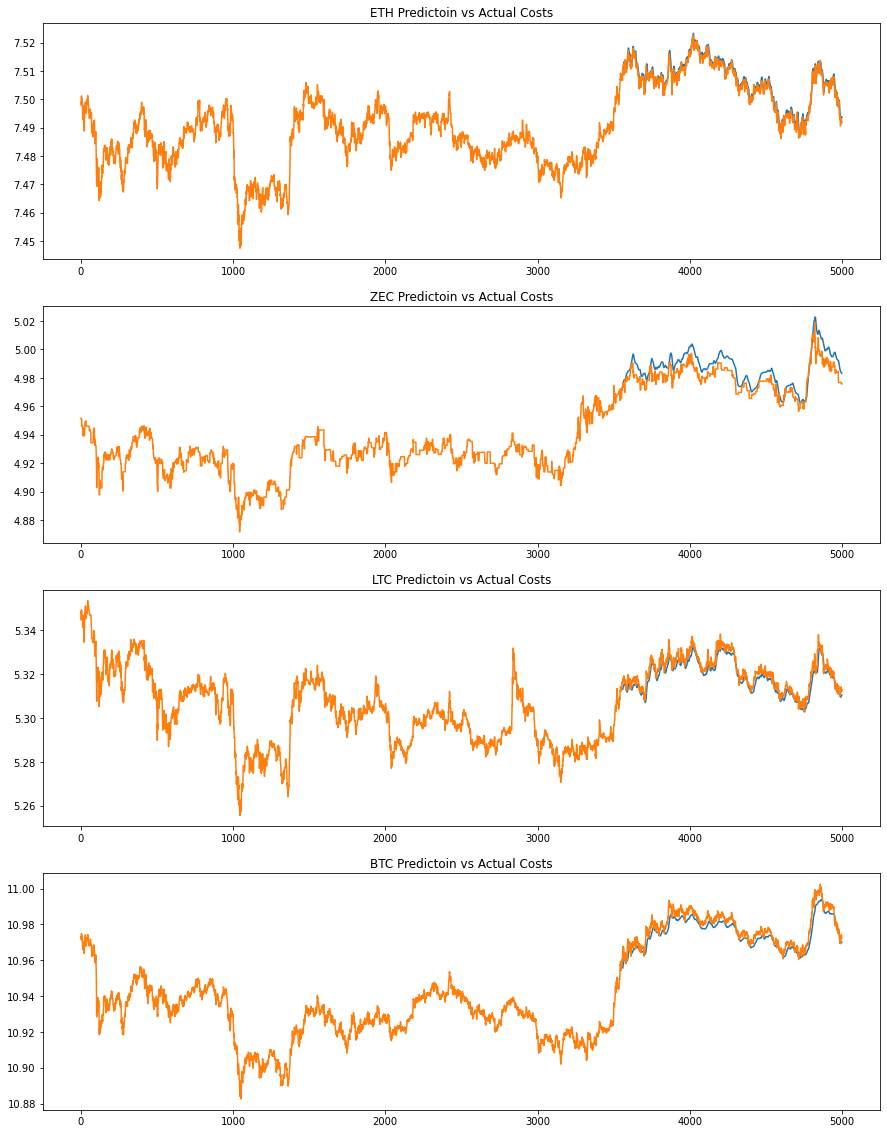

In [66]:
# Plotting the model prediction
pre_df = pd.DataFrame(valid_prediction, columns=[f'{k}_pre' for k in dict_target.keys()])
tmp_df = pd.DataFrame(np.nan, index=range(5000-1440), columns=[f'{k}_pre' for k in dict_target.keys()])

act_df = df_a[-5000:].reset_index(drop=True)
pre_df = pd.concat([tmp_df, pre_df]).reset_index(drop=True)

plot_df = pre_df.join(act_df)

plt.figure(figsize=(15,20))

for i, v in enumerate(dict_target.keys()):
    plt.subplot(4,1,i+1)
    plt.title(f'{v} Predictoin vs Actual Costs')
    plt.plot(plot_df[[f'{v}_pre',f'{v}USD_Close_log']])

plt.show()

## Test model (Only one coin Price ver.)

In [73]:
X_valid[-1]

array([[0.96181458, 0.88423664, 0.91517417, 0.9816676 ],
       [0.9620085 , 0.88423664, 0.91528142, 0.98188561],
       [0.96217587, 0.88423664, 0.91564586, 0.98184139],
       [0.96196972, 0.88423664, 0.91564586, 0.98162403],
       [0.96080431, 0.88423664, 0.91386364, 0.98049143],
       [0.96088568, 0.88423664, 0.91386364, 0.98036021],
       [0.96145641, 0.88423664, 0.91474492, 0.98135636],
       [0.96138225, 0.88423664, 0.91519562, 0.98146643],
       [0.96166642, 0.88423664, 0.91530286, 0.98121629],
       [0.96144935, 0.88423664, 0.91455162, 0.98074052],
       [0.96089982, 0.88423664, 0.91407875, 0.98015337],
       [0.96067692, 0.88423664, 0.91354077, 0.97997963],
       [0.96070346, 0.88446794, 0.91354077, 0.97971419],
       [0.96100238, 0.88113076, 0.91508835, 0.98004667],
       [0.9610943 , 0.88113076, 0.91508835, 0.98062943],
       [0.96131161, 0.88113076, 0.91508835, 0.98060798],
       [0.96127982, 0.88113076, 0.91508835, 0.98049284],
       [0.96083085, 0.88113076,

In [86]:
# best_model list for iteration
model_list = {'ETH':'50000-35-window-ETH-target-64_32_1_EachPred_batch64-1618846086',
             'ZEC':'50000-35-window-ZEC-target-64_32_1_EachPred_batch64-1618846167',
             'LTC':'50000-35-window-LTC-target-64_32_1_EachPred_batch64-1618846266',
             'BTC':'50000-35-window-BTC-target-64_32_1_EachPred_batch64-1618846365'   
}

tmp_list = []


for coin_name, model_name in model_list.items():
    # Get prediction for next 1day
    output = []
    input_x = X_valid[-1][:,dict_target[coin_name]] # Information to predict the first 100 min.
    n_step = TIME_WINDOW
    i = 0
    x_input = input_x.reshape(1,n_step,1)

    # Load best model
    best_model = tf.keras.models.load_model(f'models/best_{model_name}.h5')


    while(i<1440):
        # predict with TIME_WINDOW information 
        yhat = best_model.predict(x_input, verbose=0)
        # Remove first information (out of the range of TIME_WINDOW)
        # And append predicted result to x_input
        x_input = np.append(x_input[0][1:],yhat[0].tolist())
        x_input = x_input.reshape(1,n_step,1)
        output.append(yhat[0].tolist()[0])
        i = i+1
        if i % 100 == 0:
            print(i)
    
    tmp_list.append(output)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


In [96]:
tmp_list[1]

[0.8838683366775513,
 0.8839408159255981,
 0.8841058015823364,
 0.8843302726745605,
 0.8845939636230469,
 0.8848844766616821,
 0.8851944208145142,
 0.8855191469192505,
 0.8858556747436523,
 0.8862028121948242,
 0.8865593671798706,
 0.886925220489502,
 0.8872998952865601,
 0.8876832723617554,
 0.8880811929702759,
 0.8884878158569336,
 0.8889036178588867,
 0.8893287181854248,
 0.8897638320922852,
 0.8902088403701782,
 0.8906644582748413,
 0.8911304473876953,
 0.891607403755188,
 0.8920952081680298,
 0.8925942182540894,
 0.8931046724319458,
 0.8936265707015991,
 0.8941601514816284,
 0.8947057723999023,
 0.8952631950378418,
 0.8958330154418945,
 0.8964152336120605,
 0.897010087966919,
 0.8976175785064697,
 0.8982387781143188,
 0.898872971534729,
 0.8995159864425659,
 0.9001728296279907,
 0.900843620300293,
 0.9015282392501831,
 0.9022265672683716,
 0.902938961982727,
 0.90366530418396,
 0.9044058322906494,
 0.905160665512085,
 0.905929684638977,
 0.9067131280899048,
 0.9075111150741577,
 0

In [93]:
# Inverse transform the scaled data# 
predict_list = []
for i, v in enumerate(dict_scaler.keys()):
    predict_list.append(dict_scaler[v].inverse_transform(np.array(tmp_list[i]).reshape(-1,1)))
# stack the predict results 
sub_prediction = np.column_stack(predict_list)


In [94]:
sub_prediction

array([[ 7.49367142,  4.98321411,  5.31048717, 10.96994086],
       [ 7.49390562,  4.98338569,  5.31037865, 10.9698751 ],
       [ 7.49429035,  4.98377624,  5.31015614, 10.96974094],
       ...,
       [ 7.60490174,  5.23906464,  5.24106194, 10.64452115],
       [ 7.60490174,  5.23906464,  5.24106167, 10.64452115],
       [ 7.60490174,  5.23906464,  5.24106153, 10.64452115]])

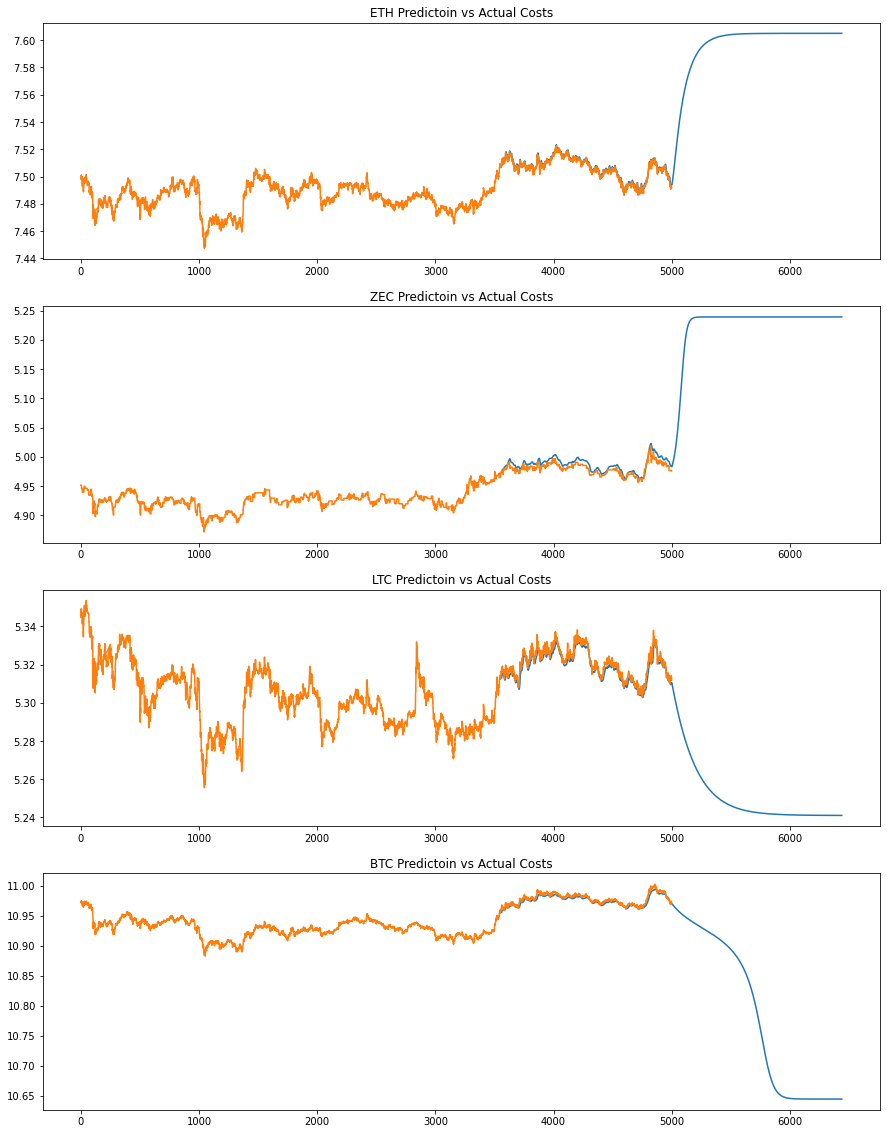

In [95]:
# Plotting the model prediction
pre_df = pd.DataFrame(valid_prediction, columns=[f'{k}_pre' for k in dict_target.keys()])
tmp_df = pd.DataFrame(np.nan, index=range(5000-1440), columns=[f'{k}_pre' for k in dict_target.keys()])

act_df = df_a[-5000:].reset_index(drop=True)
pre_df = pd.concat([tmp_df, pre_df]).reset_index(drop=True)
pre_df = pd.concat([pre_df, pd.DataFrame(sub_prediction,columns=[f'{k}_pre' for k in dict_target.keys()])]).reset_index(drop=True)

plot_df = pre_df.join(act_df)

plt.figure(figsize=(15,20))

for i, v in enumerate(dict_target.keys()):
    plt.subplot(4,1,i+1)
    plt.title(f'{v} Predictoin vs Actual Costs')
    plt.plot(plot_df[[f'{v}_pre',f'{v}USD_Close_log']])

plt.show()

## Make submit file

In [97]:
sub_file = pd.read_csv('data/sample_submission.csv')
desc = NAME

pre_1 = sub_prediction[:,0].tolist()
pre_2 = sub_prediction[:,1].tolist()
pre_3 = sub_prediction[:,2].tolist()
pre_4 = sub_prediction[:,3].tolist()

sub_file['ETHUSD_Close_log'] = pre_1
sub_file['ZECUSD_Close_log'] = pre_2
sub_file['LTCUSD_Close_log'] = pre_3
sub_file['BTCUSD_Close_log'] = pre_4

sub_file.to_csv(f'data/test_sub_{desc}.csv', index=False)

In [99]:
NAME

'50000-35-window-BTC-target-64_32_1_EachPred_batch64-1618846365'

In [98]:
pd.read_csv(f'data/test_sub_{desc}.csv')

,Date,ETHUSD_Close_log,ZECUSD_Close_log,LTCUSD_Close_log,BTCUSD_Close_log
0,00:00:00,7.493671,4.983214,5.310487,10.969941
1,00:01:00,7.493906,4.983386,5.310379,10.969875
2,00:02:00,7.494290,4.983776,5.310156,10.969741
3,00:03:00,7.494747,4.984308,5.309873,10.969561
4,00:04:00,7.495248,4.984932,5.309559,10.969351
...,...,...,...,...,...
1435,23:55:00,7.604902,5.239065,5.241062,10.644521
1436,23:56:00,7.604902,5.239065,5.241062,10.644521
1437,23:57:00,7.604902,5.239065,5.241062,10.644521
1438,23:58:00,7.604902,5.239065,5.241062,10.644521


In [317]:
0.6

,Date,ETHUSD_Close_log,ZECUSD_Close_log,LTCUSD_Close_log,BTCUSD_Close_log
0,00:00:00,7.501515,4.977207,5.331532,10.927858
1,00:01:00,7.501629,4.977484,5.331929,10.927977
2,00:02:00,7.501986,4.978034,5.332710,10.928178
3,00:03:00,7.502527,4.978713,5.333758,10.928409
4,00:04:00,7.503171,4.979380,5.334933,10.928612
...,...,...,...,...,...
1435,23:55:00,7.525734,4.928570,5.327002,10.877278
1436,23:56:00,7.525734,4.928570,5.327002,10.877278
1437,23:57:00,7.525734,4.928570,5.327002,10.877278
1438,23:58:00,7.525734,4.928570,5.327002,10.877278
